<u>**IMPORTANT NOTE**</u>

>Please proceed with this example **iff** you are familier with foundation of Microsoft Azure public cloud. In this notebook, the basics of Microsoft Azure and its development methodology is not covered. As it will be beyond the scope of this notebook.

* [PART 1: Azure Machine Learning service - Introduction](https://www.kaggle.com/pankaj1234/azure-machine-learning-introduction): in the first notebook I have already discussed about the nitty-gritty of Azure ML service.
    * Creating an instance of Azure ML service
    * Downloading libraries/dependencies (in Kaggle environment)
    * Various methods to connect to Azure ML service workspace: using config file and using get() method.
    * Simple ML experiment - for data exploration. Capture the details from the experiment, logging and preserving the run details from the experiment.
    * Overview of Azure ML Service Dashboard. Experiment Dashboard.
    
* [PART 2: Azure Machine Learning service - Introduction II](https://www.kaggle.com/pankaj1234/azure-machine-learning-introduction-ii): I did deep-dive into the introduction and covered some more topics:
    * Create and run the experiment using <u>Custom Script</u> file. Implementing simple Logistic Regression model on IRIS dataset.
    * RunConfiguration and ScriptRunConfiguration, these classes were used to define the runtime environment for the custom script.
    * Output the model and run details to the external folder for future referencing.

* [PART 3: Azure Machine Learning service - Model Training](https://www.kaggle.com/pankaj1234/azure-machine-learning-model-training): I discussed about: 
    * Create and run the experiment using <u>Parameterized Custom Script</u> file. Passing a parameter value uning argparse allowed me to run the experiment using different settings.
    * **ESTIMATOR** object was used to encapsulate both RunConfiguration and ScriptRunConfiguration. Also dicussed about Generic estimator and frame-work specific estimators such as SKLearn, TensorFlow, etc... 
    * Register the model, model versions and its metadata. It is the foundation of any model deployment over various compute with its dependencies (this i will discuss much later). 
# Azure Machine Learning Service - Working with Data
In this fourth part from the same Azure Machine Learning Service (**AML**) series I will do a experiment to :
    * Describe cloud **DATASTORES** and ways to use and manage them in a ML project. 
    * Enable remote **DataSets** to train any registered models.

## Import AML libraries & workspace
The following (hidden) section will load required AML libraries and workspace required to run the experiment.

In [ ]:
# import the Azure ML libs.
!pip install azureml
!pip install azureml.core
!pip install azureml.widgets
!pip install azureml.train
!pip install azureml.dataprep

import azureml.core
import azureml.widgets 
print("Ready to use Azure ML", azureml.core.VERSION)
from azureml.core import Workspace

In [ ]:
## In this segment you should replace the 3-parameters values according to the workspace available in the subscription
## ths experiment will not work beyond this point if these values are not appropriatly inserted.
## HENCE, THE Notebook Execution will terminate

## Example - 
    ## ws = Workspace.get(name="<<MLSERVICENAME>>", subscription_id='<<GUID - ML Service ID>>', resource_group='<<Hosting Azure Resource Group>>')

# Pulling values from Kaggle Secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
MLServiceName = user_secrets.get_secret("MLServiceName")
az_resource_grp = user_secrets.get_secret("az_resource_grp")
sub_id = user_secrets.get_secret("sub_id")

## Instanciating the Workspace object.
ws = Workspace.get(name=MLServiceName, subscription_id=sub_id, resource_group=az_resource_grp)
print(ws.name, "loaded")

## Datastores
- Datastores are reference to the datastorage location in AML workspaces.
- These are two types - Default and user provisioned, such as: Storage Blobs containers or file storage

### Following code gives us the default datastore assigned to the workspace

In [ ]:
# get the name of defult Datastore associated with the workspace.
default_dsname = ws.get_default_datastore().name
default_ds = ws.get_default_datastore()
print('default Datastore = ', default_dsname)

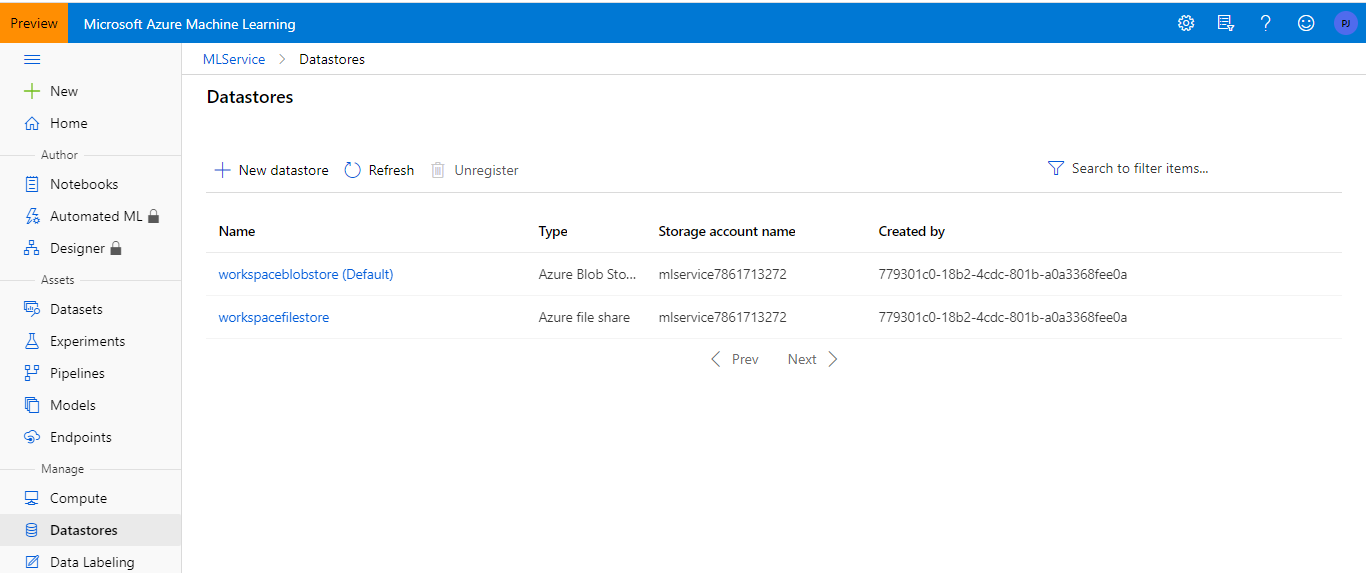

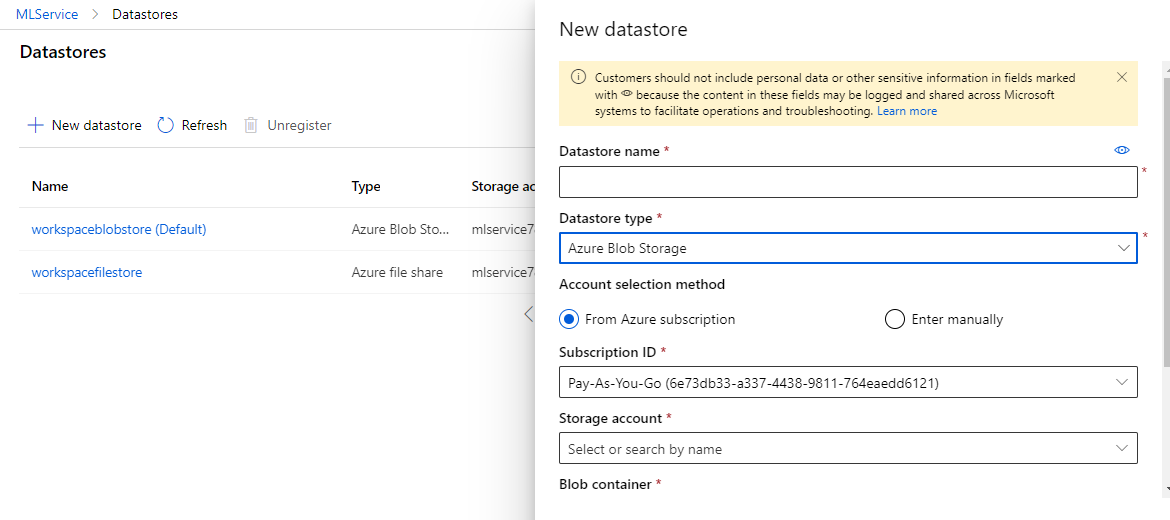

## Upload to Datastore
- Upload the local files from the local-system to the remote datastore.
- This allows the experiments to directly run using remote data location.
- Hence the experiments are no longer dependent on the data availablity regardless of any compute been used.

- The *target_path* is the path of the files at remote datasrote location
- The *'Reference Path'* is returned once the files are uploaded to the datastore. 

In [ ]:
default_ds.upload_files(files=['../input/iris-flower-dataset/IRIS.csv'],
                 target_path='flower_data/',
                 overwrite=True, show_progress=True)

flower_data_ref = default_ds.path('flower_data').as_download('ex_flower_data')
print('reference path = ',flower_data_ref)

## Train Model from Datastore
- Create  experiment location in the workspace: 'datastore-experiment-files'
- Initialize the training Script
    - Added the additional '--data_folder' argument to pass the reference path of the datastore location as returned while uploading the files to the datastore.
    - Once the reference path is extracted, the path is iterated in the experiment script to create a Panda Dataframe

In [ ]:
import os, shutil

# Create a folder for the experiment files
folder_name = 'datastore-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(experiment_folder, exist_ok=True)

In [ ]:
%%writefile $folder_name/iris_simple_experiment.py
from azureml.core import Run
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib
import os

#"argparse" to define the input parameters for the script.
import argparse

# Get the experiment run context -  we are going to pass this configuration later
run = Run.get_context()

#define the regularization parameter for the logistic regression.
parser = argparse.ArgumentParser()
parser.add_argument('--reg_rate', type=float, dest='reg', default=0.01)

#define the data_folder parameter for referencing the path of the registerd datafolder.
parser.add_argument('--data_folder', type=str, dest='data_folder', help='Data folder reference')
args=parser.parse_args()
r = args.reg
ex_data_folder = args.data_folder

#look into the files in datafolder
all_files = os.listdir(ex_data_folder)

# load the data from a local file
data = pd.concat((pd.read_csv(os.path.join(ex_data_folder,file)) for file in all_files))

X = data[['sepal_length', 'sepal_width','petal_length','petal_width']].values
X=StandardScaler().fit_transform(X)
Y= (data['species']).map(lambda x: 0 if x=='Iris-setosa' else (1 if x=='Iris-versicolor' else 2))

#Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=1234)
# fit the model
run.log("model regularization", np.float(r))
model = LogisticRegression(C=1/r, solver='lbfgs', multi_class='multinomial').fit(X_train,Y_train)

Y_pred = model.predict(X_test)
accuracy = np.average(Y_test == Y_pred)
print("accuracy: " + str(accuracy))
run.log("Accuracy", np.float(accuracy))

# Save the trained model in the "outputs" folder. The "outputs" folder is standard output folder for AML.
os.makedirs("outputs", exist_ok=True)
joblib.dump(value=model, filename='outputs/iris_simple_model.pkl')
# Complete the run
run.complete()

> **NOTE**: The *'--data_folder'* accepts the datastore folder reference; path where files are uploaded. The script will load the training data from the data reference passed to it as a parameter, hence I just need to set up the script parameters to pass the file reference I run the experiment.

In [ ]:
from azureml.train.sklearn import SKLearn ## note - directly using SKLearn as estimator, hence avoid using conda_packages
from azureml.core import Experiment
from azureml.widgets import RunDetails

# Create an estimator, look into the 'data_folder' additional parameter and reference path as value
estimator = SKLearn(source_directory=experiment_folder,
                      entry_script='iris_simple_experiment.py',
                      compute_target='local',
                      use_docker=False,
                      script_params = {'--reg_rate': 0.07, '--data_folder':flower_data_ref} # assigned reference path value as defined above.
                      )

# Create an experiment
experiment_name = 'iris-datastore-experiment'
experiment = Experiment(workspace = ws, name = experiment_name)

# Run the experiment based on the estimator
run = experiment.submit(config=estimator)

# Get Run Details
RunDetails(run).show()

# Wait to complete the experiment. In the Azure Portal we will find the experiment state as preparing --> finished.
run.wait_for_completion(show_output=True)

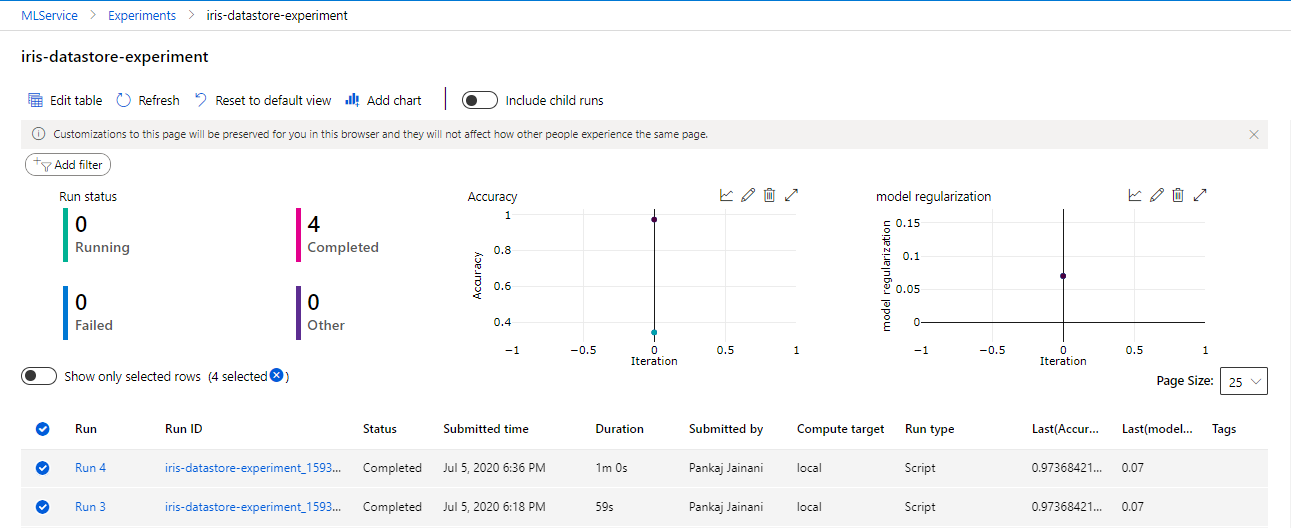

## Datasets
- AML provides a further abstraction for data in the form of **datasets**. 
- A dataset is a versioned reference to a specific set of data that we want to use in an experiment. 
- Datasets can be tabular or file-based, both examples are shown in below code segment.
- Datasets are defined from the location of data stored already in the 'DataStore'

In [ ]:
from azureml.core import Dataset

# Creating tabular dataset from files in datastore.
tab_dataset = Dataset.Tabular.from_delimited_files(path=(default_ds,'flower_data/*.csv'))
tab_dataset.take(10).to_pandas_dataframe()

# similarly, creating files dataset from the files already in the datastore. Useful in scenarios like image processing in deeplearning.
file_dataset = Dataset.File.from_files(path=(default_ds,'flower_data/*.csv'))
for fp in file_dataset.to_path():
    print(fp)

## Register Datasets
- Once the Datasets are defined, they are required to be attached to a AML workspace
- Also, meta-data such as name,description, tags and version of the dataset is appended.
- Versioning allows to keep track of dataset on which the experiment is trained.
- Versioning is also useful if we want to train the model on any specific version.

In [ ]:
# register tabular dataset
tab_dataset = tab_dataset.register(workspace=ws, name='flower tab ds', description='Iris flower Dataset in tabular format', tags={'format':'CSV'}, create_new_version=True)
#register File Dataset
file_dataset = file_dataset.register(workspace=ws, name='flower Files ds', description='Iris flower Dataset in Files format', tags={'format':'CSV'}, create_new_version=True)

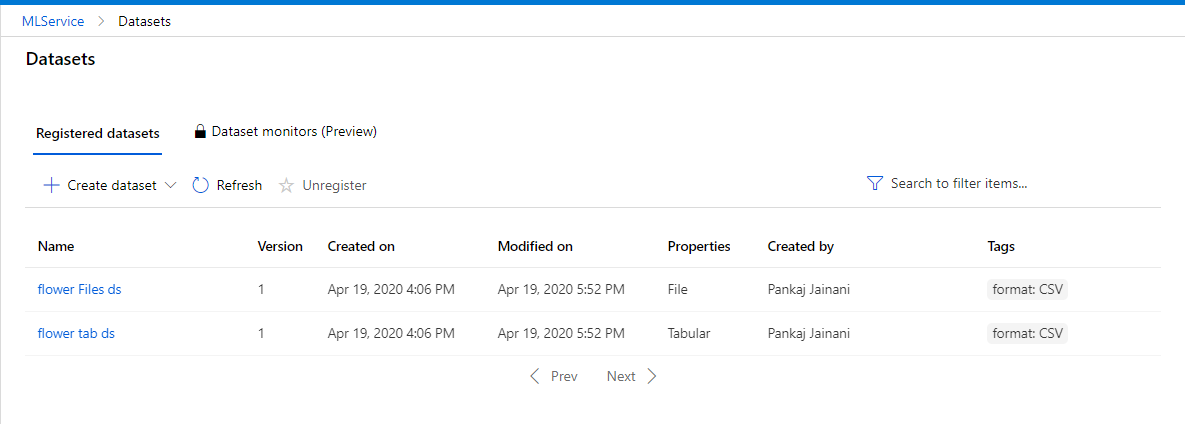

In [ ]:
print("Datasets:")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name, 'version', dataset.version)

## Train Model with registered Dataset
- The training script that trains a classification model, the  **tabular dataset** is passed to it as an **input**. 
  <br/>data = run.input_datasets['flower_ds'].to_pandas_dataframe()
- Use the **inputs** parameter of the **SKLearn estimator** to pass the regisered dataset, which is to be consumed by the training script.
  <br/>inputs=[tab_dataset.as_named_input('flower_ds')]
- Also, using pip_packages additional parameter to enable the runtime environment to provision required package to support AML pandas operations.
  <br/>pip_packages=['azureml-dataprep[pandas]']

In [ ]:
tab_ds_experiment = "tab_dataset_experiment"
os.makedirs(tab_ds_experiment,exist_ok=True)
print(tab_ds_experiment, 'created')

In [ ]:
%%writefile $tab_ds_experiment/iris_simple_DTexperiment.py
from azureml.core import Run
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Get the experiment run context -  we are going to pass this configuration later
run = Run.get_context()

#define the regularization parameter for the logistic regression.
parser = argparse.ArgumentParser()
parser.add_argument('--reg_rate', type=float, dest='reg', default=0.01)
args=parser.parse_args()
r = args.reg

# load the data from a dataset -  passed as an "inputs" to the script
data = run.input_datasets['flower_ds'].to_pandas_dataframe()
X = data[['sepal_length', 'sepal_width','petal_length','petal_width']].values
X=StandardScaler().fit_transform(X)
Y= (data['species']).map(lambda x: 0 if x=='Iris-setosa' else (1 if x=='Iris-versicolor' else 2))

#Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=1234)
# fit the model
model = LogisticRegression(C=1/r, solver='lbfgs', multi_class='multinomial').fit(X_train,Y_train)

Y_pred = model.predict(X_test)
accuracy = np.average(Y_test == Y_pred)
print("accuracy: " + str(accuracy))
run.log("Accuracy", np.float(accuracy))

# Save the trained model in the "outputs" folder. The "outputs" folder is standard output folder for AML.
os.makedirs("outputs", exist_ok=True)
joblib.dump(value=model, filename='outputs/iris_simple_DTmodel.pkl')
# Complete the run
run.complete()

In [ ]:
from azureml.train.sklearn import SKLearn ## note - directly using SKLearn as estimator, hence avoid using conda_packages
from azureml.core import Experiment, Dataset
from azureml.widgets import RunDetails

# Get the previously registered tabular flower dataset
tab_dataset = ws.datasets.get('flower tab ds')

# Create an estimator, look into the 'data_folder' additional parameter and reference path as value
estimator = SKLearn(source_directory=tab_ds_experiment, ## pointing to the correct experiment folder for this context
                      entry_script='iris_simple_DTexperiment.py',
                      compute_target='local',
                      use_docker=False,
                      inputs=[tab_dataset.as_named_input('flower_ds')], ## pass the 'tab_dataset' as input to the experiment
                      pip_packages=['azureml-dataprep[pandas]']   ## passing azureml-dataprep to provision this package at runtime on execution env.
                      )

# Create an experiment
experiment_name = 'iris-dataset-experiment'
experiment = Experiment(workspace = ws, name = experiment_name)

# Run the experiment based on the estimator
run = experiment.submit(config=estimator)

# Get Run Details
RunDetails(run).show()

# Wait to complete the experiment. In the Azure Portal we will find the experiment state as preparing --> finished.
run.wait_for_completion(show_output=True)

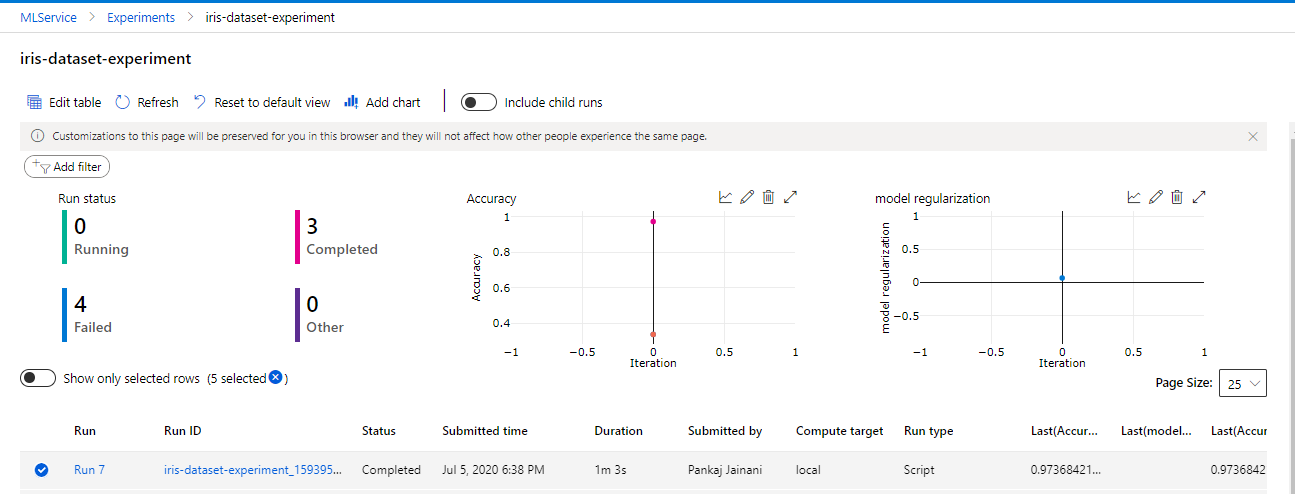

## Conclusion
From this experiment Notebook I was able to demonstrate:
- Concepts of DataStores and Dataset so that they are used to provision data while the experiment is running, irrespective of type of environment.
- Learnt about Tabular (supporting pandas like structure) and Files (suitable for image processing in CV) datasets.
- Versioning of Datasets gives the fine control on the data on which the model is trained.
